In [17]:
import combined_threshold as combined_threshold
import undistort_transform as undistort_transform
import glob as glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
print("Imported All Combined Libraries!")

def pipeline(img):
    with open('output_images/calibrate_camera.p', 'rb') as f:
        save_dict = pickle.load(f)
    mtx = save_dict['mtx']
    dist = save_dict['dist']

    img = cv2.undistort(img, mtx, dist, None, mtx)
    img, combined2, abs_bin, mag_bin, dir_bin, hls_s_bin, lab_b_bin, hls_l_bin = combined_threshold.combined_thresh(img)

    warped, unwarped, m, m_inv = undistort_transform.perspective_transform(img)

    return warped, unwarped, m_inv

Imported All Combined Libraries!


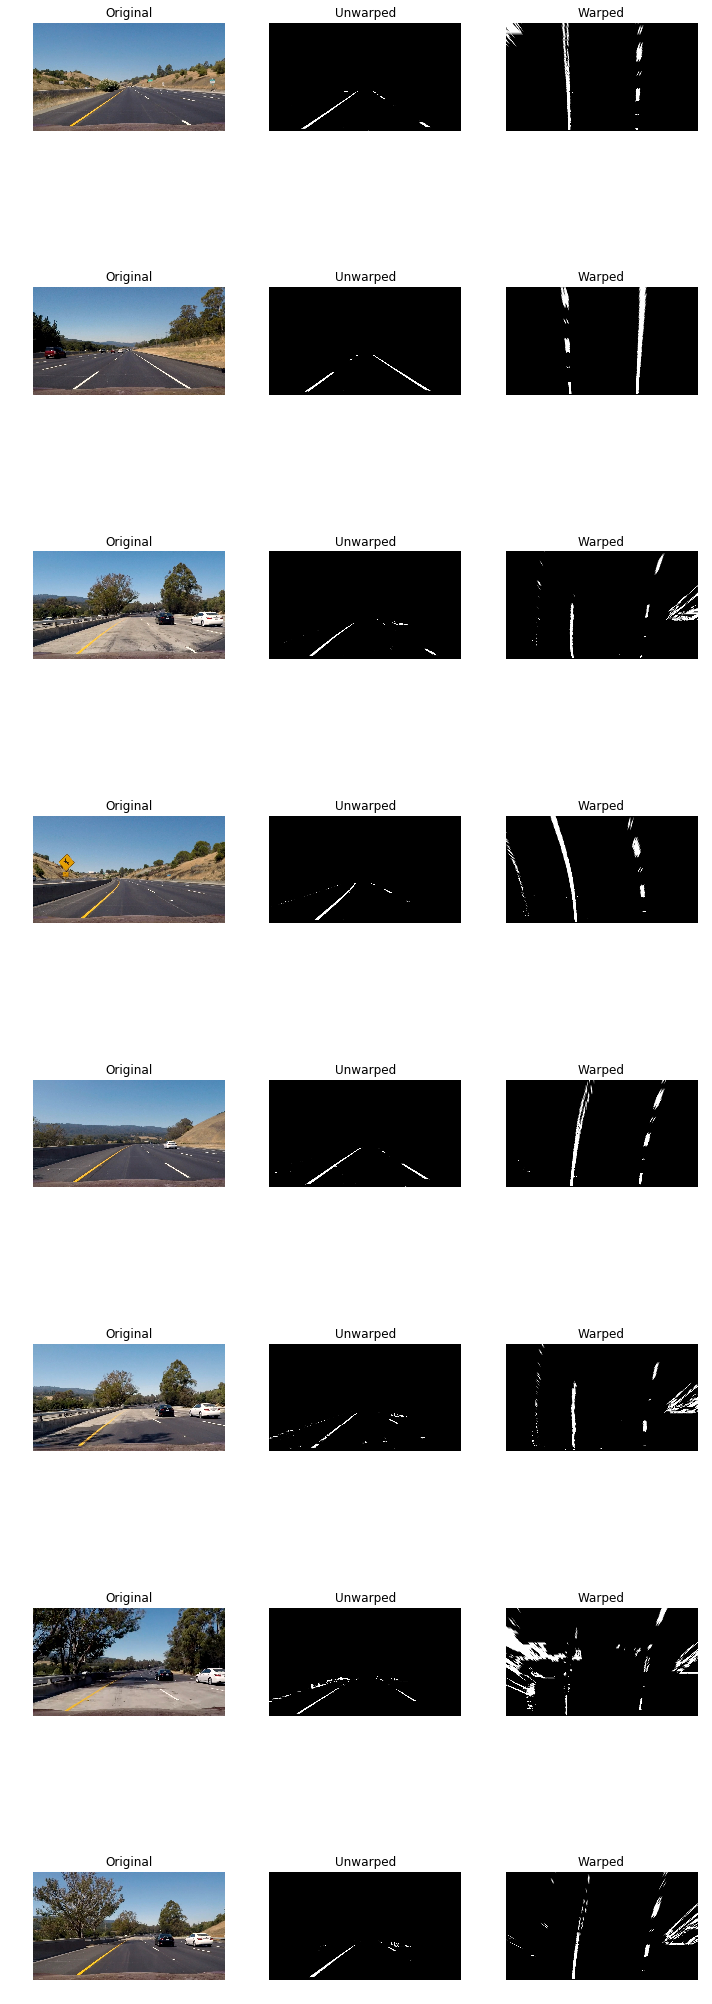

In [21]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 30))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, img_unw, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Original")
    i += 1
    axs[i].imshow(img_unw, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Unwarped")
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Warped")
    i += 1
plt.tight_layout()
plt.savefig('output_images/pipeline.jpg')
plt.show()